In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import warnings
warnings.filterwarnings("ignore")
import TinySleepNet
import wandb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import DatasetsPaco
from wandb.keras import WandbCallback
from plotUtils import *

In [2]:
# wandb.init()

In [3]:
# parameters 
binary_labels = True
channels = ['F4', 'O2']
batch_size = 32

In [4]:
train_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG1.edf", channels=channels)
test_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG2.edf", channels=channels)
val_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG3.edf", channels=channels)

In [5]:
# parameters <= da integrare in una util con l'our generator?
# => safe computarlo cosí? o da dentro un metodo get della classe? =>
pts_per_epoch = train_dataset.epochs.get_data().shape[-1] 
sampling_rate = int(train_dataset.sampling_rate)
output_classes = len(train_dataset.id_to_class_dict)

In [6]:
# same generator => ?
def train_generator():
    for x, y in train_dataset:
        yield x,y

def test_generator():
    for x, y in test_dataset:
        yield x,y

def val_generator():
    for x, y in val_dataset:
        yield x,y

train_dataset_generator = tf.data.Dataset.from_generator(train_generator,output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
test_dataset_generator = tf.data.Dataset.from_generator(test_generator, output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)
val_dataset_generator = tf.data.Dataset.from_generator(val_generator, output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)

In [7]:
model = TinySleepNet.TinySleepNet(sampling_rate, len(channels), output_classes)

In [8]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
history = model.fit(train_dataset_generator, epochs=50, validation_data=val_dataset_generator) # , callbacks=[WandbCallback()])
model.summary()

Epoch 1/50
20/20 [==============================] - 7s 186ms/step - loss: 3.3241 - accuracy: 0.3396 - val_loss: 1.3785 - val_accuracy: 0.2479
Epoch 2/50
20/20 [==============================] - 6s 190ms/step - loss: 1.2020 - accuracy: 0.4041 - val_loss: 1.3024 - val_accuracy: 0.4135
Epoch 3/50
20/20 [==============================] - 6s 187ms/step - loss: 1.2312 - accuracy: 0.5157 - val_loss: 1.3492 - val_accuracy: 0.4479
Epoch 4/50
20/20 [==============================] - 6s 190ms/step - loss: 1.0630 - accuracy: 0.5660 - val_loss: 1.4200 - val_accuracy: 0.3571
Epoch 5/50
20/20 [==============================] - 6s 175ms/step - loss: 1.1005 - accuracy: 0.5503 - val_loss: 1.3122 - val_accuracy: 0.4479
Epoch 6/50
20/20 [==============================] - 6s 191ms/step - loss: 1.0460 - accuracy: 0.5849 - val_loss: 1.3243 - val_accuracy: 0.4479
Epoch 7/50
20/20 [==============================] - 6s 196ms/step - loss: 1.0055 - accuracy: 0.5676 - val_loss: 1.3588 - val_accuracy: 0.4110
Epoch 

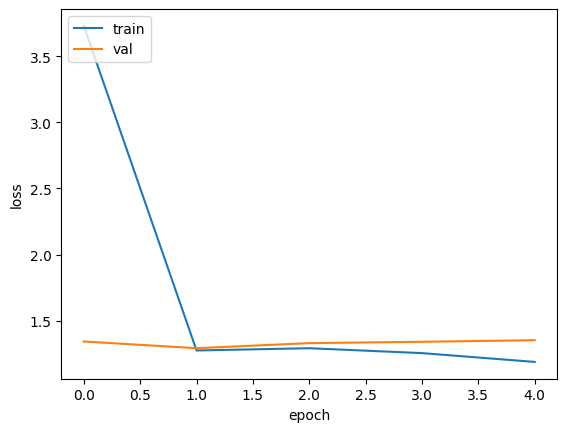

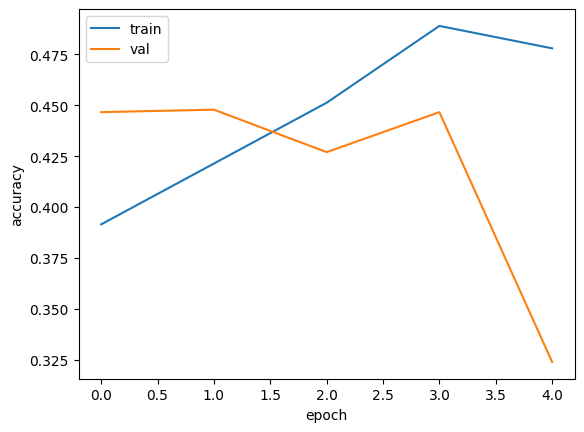

In [ ]:
plot_history(history)

In [ ]:
# test confusion => anche se inefficientemente cargo en memo e riconversione in array => ?

y_real = []
y_pred = []

for x, y in test_dataset_generator:
    y_real.extend(y.numpy())
    y_pred_batch = model.predict(x)
    y_pred_batch = np.argmax(y_pred_batch, axis=-1)
    y_pred.extend(y_pred_batch)

y_real = np.array(y_real)
y_pred = np.array(y_pred)

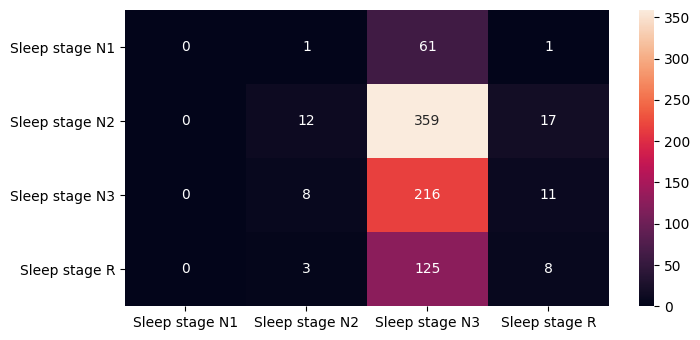

In [ ]:
plot_cm(y_real, y_pred, train_dataset.id_to_class_dict.values())

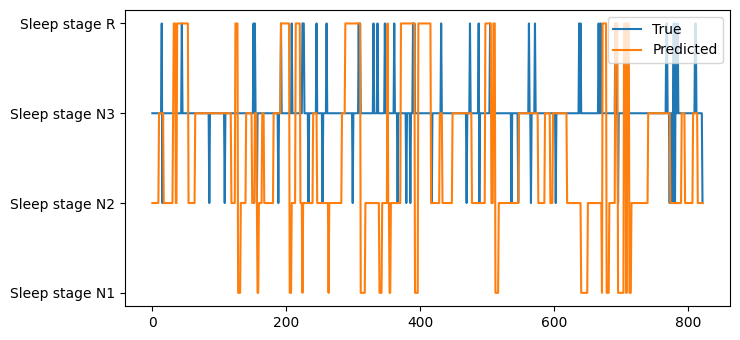

In [ ]:
plot_hypnogram(y_real, y_pred, train_dataset.id_to_class_dict)